In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import pickle
from tqdm import tqdm
import re
import json
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
from collections import Counter
from pensmodule.Generator.train import *
import json
import matplotlib.pyplot as plt

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda:0')

## Prepare

- **Config & Data**

In [3]:
from data import *
with open('config.json') as f:
    config = json.load(f)

In [4]:
sources = np.load('../../data2/sources.npy')
target_inputs = np.load('../../data2/target_inputs.npy')
target_outputs = np.load('../../data2/target_outputs.npy')
embedding_matrix = np.load('../../data2/embedding_matrix.npy')
with open('../../data2/dict.pkl', 'rb') as f:
    news_index,category_dict,word_dict = pickle.load(f)
index2word = {}
for k,v in word_dict.items():
    index2word[v] = k
print(len(word_dict),embedding_matrix.shape)

141910 (141910, 300)


- **Model**

In [5]:
import sys
print(sys.executable)


e:\anaconda3\envs\pens_clean\python.exe


In [6]:
from pensmodule.Generator import HeadlineGen
model = HeadlineGen(config['model'], embedding_matrix, index2word, device, pointer_gen=True).to(device)

C:\Users\13174\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [ ]:
from pensmodule.UserEncoder import NRMS # 这里\UserEncoder\model.py里要用from .modules

usermodel = NRMS(embedding_matrix)
usermodel.load_state_dict(torch.load('../../runs/userencoder/NAML-2.pkl'))
usermodel = usermodel.to(device)
usermodel.eval()

NRMS(
  (embed): Embedding(141910, 300, padding_idx=0)
  (attn_word): MultiHeadAttention(
    (W_Q): Linear(in_features=300, out_features=400, bias=True)
    (W_K): Linear(in_features=300, out_features=400, bias=True)
    (W_V): Linear(in_features=300, out_features=400, bias=True)
  )
  (attn_pool_word): AttentionPooling(
    (att_fc1): Linear(in_features=400, out_features=200, bias=True)
    (att_fc2): Linear(in_features=200, out_features=1, bias=True)
    (drop_layer): Dropout(p=0.2, inplace=False)
  )
  (attn_pool_news): AttentionPooling(
    (att_fc1): Linear(in_features=64, out_features=32, bias=True)
    (att_fc2): Linear(in_features=32, out_features=1, bias=True)
    (drop_layer): Dropout(p=0.2, inplace=False)
  )
  (drop_layer): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=400, out_features=64, bias=True)
  (criterion): CrossEntropyLoss()
)

- **Load Trainer**

In [8]:
# here you can set different modes for computing coverage scores
trainer = Trainer(config, model, usermodel, device, mode=4, experiment_name='exp')

## Pretrain Seq2seq model

**Noted:**\
**For a fair comparison, here we advise using other source and targets (from your own collected news datasets) for pretraining.**

In [9]:
global_user_embed = np.load('../../data2/global_user_embed2.npy')
global_user_embed = torch.as_tensor(global_user_embed, device=device).float()

In [10]:
trainer._init_optimizer()

In [ ]:
for epoch in range(1,4):
    print('epoch:', epoch)
    s_dset = Seq2SeqDataset(sources, target_inputs, target_outputs)
    train_iter = DataLoader(s_dset, batch_size=128, shuffle=True, num_workers=20, pin_memory=True)
    
    trainer.pretrain(train_iter, global_user_embed)
    trainer.save_checkpoint(tag='pretrain_epoch_'+str(epoch))

epoch: 1


pretrain loss: 54.634:  46%|████▌     | 500/1094 [06:57<06:45,  1.47it/s]  

step= 500, pretrain loss: 61.886


pretrain loss: 49.513:  90%|████████▉ | 981/1094 [12:25<01:25,  1.32it/s]

## Train Personalized Generator

- **data loader**

In [ ]:
with open('../../data2/TrainUsers.pkl', 'rb') as f:
    TrainUsers = pickle.load(f)
with open('../../data2/TrainSamples.pkl', 'rb') as f:
    TrainSamples = pickle.load(f)

In [ ]:
news_scoring = np.load('../../data2/news_scoring2.npy')

In [ ]:
i_dset = ImpressionDataset(news_scoring, sources, target_inputs, target_outputs, TrainUsers, TrainSamples)
data_loader = DataLoader(i_dset, batch_size=128, shuffle=True, num_workers=20, pin_memory=True)

- **train**

In [ ]:

# trainer.load_checkpoint(tag='pretrain_epoch_3', weights_only=False)
tag='pretrain_epoch_3'
path = os.path.join(trainer.experiment_path,
                                "checkpoint_{}.pth".format(tag))
checkpoint = torch.load(path, weights_only=False)

trainer.model = checkpoint['model']
trainer.step = int(checkpoint['step'])

print('Loaded ' + path)

Loaded ../../runs/seq2seq\exp\checkpoint_pretrain_epoch_3.pth


In [ ]:
trainer._init_evaluator_()

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

e:\anaconda3\envs\pens_clean\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\13174\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better perfo

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

e:\anaconda3\envs\pens_clean\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
trainer._init_context_()

loading news body


In [ ]:
optimizer_params={'lr': 0.000001}
scheduler_params={'step_size': 200, 'gamma': 0.98}
trainer._init_optimizer(optimizer_params=optimizer_params,scheduler_params=scheduler_params)

In [ ]:
rewards = trainer.train(data_loader,train_option='a2c', tag='mod4')

train actor loss: 0.062, train critic loss: 0.393, train reward: 3.030:   8%|▊         | 500/5963 [1:05:06<12:24:37,  8.18s/it] 

Saved ../../runs/seq2seq\exp\checkpoint_train_mod4_step_500.pth
step= 500, train actor loss: -0.068, train critic loss: 0.393, train reward: 2.983


train actor loss: 0.217, train critic loss: 0.373, train reward: 3.082:  17%|█▋        | 1000/5963 [2:11:21<11:35:42,  8.41s/it]

Saved ../../runs/seq2seq\exp\checkpoint_train_mod4_step_1000.pth
step=1000, train actor loss: -0.048, train critic loss: 0.373, train reward: 3.082


train actor loss: -0.186, train critic loss: 0.341, train reward: 3.167:  25%|██▌       | 1500/5963 [3:18:20<10:11:06,  8.22s/it]

Saved ../../runs/seq2seq\exp\checkpoint_train_mod4_step_1500.pth
step=1500, train actor loss: -0.059, train critic loss: 0.341, train reward: 3.176


train actor loss: -0.310, train critic loss: 0.331, train reward: 3.270:  34%|███▎      | 2000/5963 [4:26:26<9:04:32,  8.24s/it] 

Saved ../../runs/seq2seq\exp\checkpoint_train_mod4_step_2000.pth
step=2000, train actor loss: -0.142, train critic loss: 0.331, train reward: 3.275


train actor loss: -0.140, train critic loss: 0.306, train reward: 3.355:  42%|████▏     | 2500/5963 [5:35:33<8:27:29,  8.79s/it]

Saved ../../runs/seq2seq\exp\checkpoint_train_mod4_step_2500.pth
step=2500, train actor loss: -0.135, train critic loss: 0.306, train reward: 3.344


train actor loss: 0.085, train critic loss: 0.317, train reward: 3.449:  50%|█████     | 3000/5963 [6:45:08<6:56:05,  8.43s/it] 

Saved ../../runs/seq2seq\exp\checkpoint_train_mod4_step_3000.pth
step=3000, train actor loss: -0.175, train critic loss: 0.317, train reward: 3.414


train actor loss: -0.036, train critic loss: 0.314, train reward: 3.434:  50%|█████     | 3000/5963 [6:45:17<6:40:17,  8.11s/it]


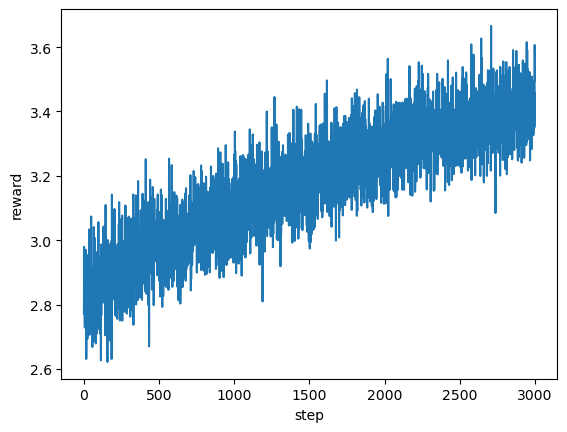

In [ ]:
x = np.arange(len(rewards))
fig = plt.gcf()
plt.plot(x[:3000],rewards[:3000])

plt.xlabel("step")
plt.ylabel("reward")
plt.show()

## Test

In [ ]:
with open('../../data2/TestUsers.pkl', 'rb') as f:
    TestUsers = pickle.load(f)
with open('../../data2/TestSamples.pkl', 'rb') as f:
    TestSamples = pickle.load(f)

In [ ]:
from pensmodule.Generator import *
model_path = '../../runs/seq2seq/exp/checkpoint_train_mod4_step_2000.pth'

def load_model_from_ckpt(path):
    checkpoint = torch.load(path, weights_only= False)
    model = checkpoint['model']
    if torch.cuda.device_count() > 1:
        print('multiple gpu training')
        model = nn.DataParallel(model)
    return model

model = load_model_from_ckpt(model_path).to(device)
model.eval()

HeadlineGen(
  (embeddings): Embedding(141910, 300)
  (encoder): LSTMEncoder(
    (embeddings): Embedding(141910, 300)
    (rnn): LSTM(300, 64, batch_first=True, dropout=0.2, bidirectional=True)
    (bridge): ModuleList(
      (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (decoder): Decoder_P(
    (embeddings): Embedding(141910, 300)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): LSTM(300, 128, batch_first=True)
    (attention): Attention(
      (linear_out): Linear(in_features=256, out_features=128, bias=True)
    )
    (transform): ModuleList(
      (0-1): 2 x Linear(in_features=64, out_features=128, bias=True)
    )
    (out): Linear(in_features=128, out_features=141910, bias=True)
    (p_gen_linear): Linear(in_features=128, out_features=1, bias=True)
  )
  (loss_fn): NLLLoss()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
from pensmodule.UserEncoder import NRMS

usermodel = NRMS(embedding_matrix)
usermodel.load_state_dict(torch.load('../../runs/userencoder/NAML-2.pkl'))
usermodel = usermodel.to(device)
usermodel.eval()

NRMS(
  (embed): Embedding(141910, 300, padding_idx=0)
  (attn_word): MultiHeadAttention(
    (W_Q): Linear(in_features=300, out_features=400, bias=True)
    (W_K): Linear(in_features=300, out_features=400, bias=True)
    (W_V): Linear(in_features=300, out_features=400, bias=True)
  )
  (attn_pool_word): AttentionPooling(
    (att_fc1): Linear(in_features=400, out_features=200, bias=True)
    (att_fc2): Linear(in_features=200, out_features=1, bias=True)
    (drop_layer): Dropout(p=0.2, inplace=False)
  )
  (attn_pool_news): AttentionPooling(
    (att_fc1): Linear(in_features=64, out_features=32, bias=True)
    (att_fc2): Linear(in_features=32, out_features=1, bias=True)
    (drop_layer): Dropout(p=0.2, inplace=False)
  )
  (drop_layer): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=400, out_features=64, bias=True)
  (criterion): CrossEntropyLoss()
)

In [ ]:
i_dset = TestImpressionDataset(news_scoring, sources, TestUsers, TestSamples)
test_iter = DataLoader(i_dset, batch_size=16, shuffle=False, num_workers=20, pin_memory=True)

In [ ]:
from pensmodule.Generator.eval import predict
refs, hyps, scores1, scores2, scoresf = predict(usermodel, model, test_iter, device, index2word, beam=False, beam_size=3, eos_id=2)
# refs, hyps, scores1, scores2, scoresf = predict(usermodel, model, test_iter, device, index2word, beam=True, beam_size=3, eos_id=2)

100%|██████████| 1288/1288 [00:58<00:00, 22.04it/s]


In [ ]:
scores1.mean(), scores2.mean(), scoresf.mean()

(0.24194751508665002, 0.08631163564189903, 0.21354054768805453)